In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import TraceModel as tm

from sys import path
path.insert(1, '..')
from overlap import TrpzOverlap
from utils import grid_from_map, get_soss_grid, oversample_grid

from matplotlib.colors import LogNorm

# Create the First Pass Order 2 Trace Profile 

This procedure extracts only the first order from the data frame, using a first pass order 1 trace model as created in TraceModel_example.ipynb. After reconstructing the detector, a first pass second order profile is detemined from the leading order residuals when the reconstructed and original detectors are compared.

## Make the Order 1 Trace Profile

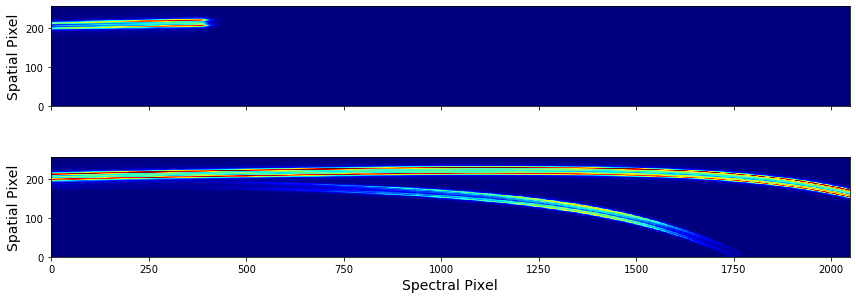

In [2]:
# Open simulated clear and F277W exposures
clear = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/simu_F277_CLEAR/clear.fits')[0].data[::-1, :]
F277 = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/simu_F277_CLEAR/f277.fits')[0].data[::-1, :]

# Visualize the frames
f, ax = plt.subplots(2, sharex=True, figsize=(12, 5))
ax[0].imshow(F277/np.nanmax(F277), origin='lower', cmap='jet')
ax[0].set_ylabel('Spatial Pixel', fontsize=14)

ax[1].imshow(clear/np.nanmax(clear, axis=0), origin='lower', cmap='jet')
ax[1].set_xlabel('Spectral Pixel', fontsize=14)
ax[1].set_ylabel('Spatial Pixel', fontsize=14)

f.tight_layout()

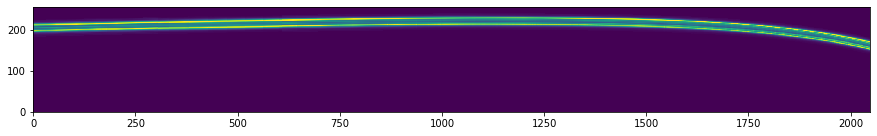

In [3]:
# Create the order 1 trace profile
tracemodel_wf277 = tm.makemod(clear, F277, do_plots=False)

# Visualize the first pass order 1 solution
plt.figure(figsize=(15, 3))
plt.imshow(tracemodel_wf277, origin='lower')

## Order 1 Extraction

### Set up the Wavelength Grid

The extraction procedure needs to be set up before the first order can be completed. This includes making the wavelength grid, which is created using the SOSS wavelength solution, evaluated at the centroid positions of each order.

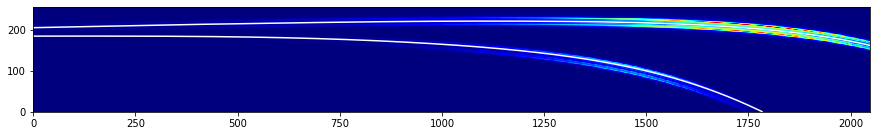

In [4]:
# Get the data centroids for orders 1 and 2
xM2, yM2, xM1, yM1 = tm.get_o2_data_centroids(clear, return_o1=True)

plt.figure(figsize=(15,3))
plt.imshow(clear, origin='lower', cmap='jet')
plt.plot(xM1, yM1, c='white')
plt.plot(xM2, yM2, c='white')

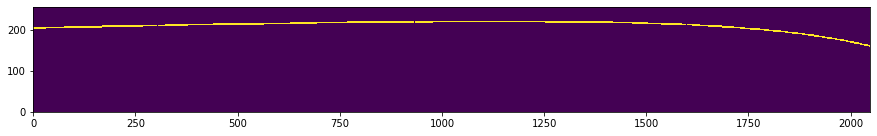

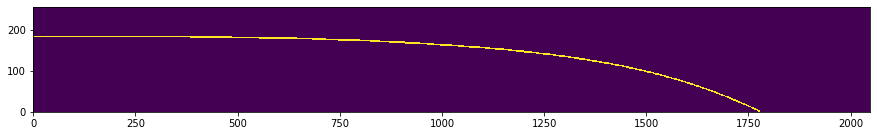

In [5]:
# Create frames with just the centroid positions for both orders
xM1 = xM1.astype(int)
xM2 = xM2.astype(int)
yM1 = yM1.astype(int)
yM2 = yM2.astype(int)

P1, P2 = np.zeros((256, 2048)), np.zeros((256, 2048))
for x, y in zip(xM1, yM1):
    P1[y-2:y+2, x] = 1
for x, y in zip(xM2, yM2):
    P2[y-2:y+2, x] = 1

# Visualize the frames
plt.figure(figsize=(15,3))
plt.imshow(P1, origin='lower')

plt.figure(figsize=(15,3))
plt.imshow(P2, origin='lower')

In [6]:
# Read wavelength solution files
wv_1 = fits.open('../Ref_files/wavelengths_m1.fits')[0].data
wv_2 = fits.open('../Ref_files/wavelengths_m2.fits')[0].data
# First order trace profile
T1 = tracemodel_wf277

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
T1 = T1.astype(float)

# Renormazlie trace profile (Should be already done, but why not repeat it)
T1 = T1 / T1.sum(axis=0)
T1[np.isnan(T1)] = 0.

Now make the wavelength grid itself. This basically just finds the wavelength at the position of the trace centroid in each column. The second order is preferred in wavelength regions where the two orders overlap due to having a higher spectral resolution.

In [7]:
# Make the extraction wavelength grid.
lam_grid = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=1)

### Extract Only the First Order

In [8]:
# Set up the extraction object
extra = TrpzOverlap([T1], [wv_1], orders=[0], scidata=clear, lam_grid=lam_grid, thresh=1e-9,
                    c_kwargs={'thresh':0.0001})

In [9]:
# Extract the first order spectrum, then rebuild the detector using the results of the extraction. 
f_k = extra.extract()
rebuilt = extra.rebuild(f_k)

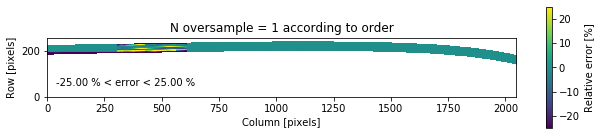

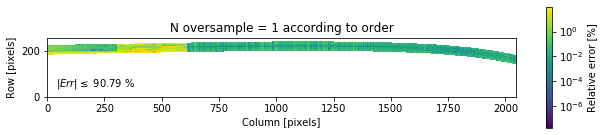

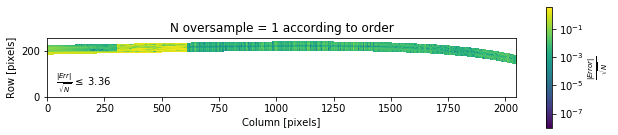

In [10]:
scidata = clear

# Look at errors
n_oversample=1
plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow((rebuilt-scidata)/scidata * 100, origin='lower', vmin=-25, vmax=25)
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,46, "{:.2f} % < error < {:.2f} %".format(cmap.vmin, cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow(np.abs(rebuilt-scidata)/scidata * 100, norm=LogNorm(), origin='lower')
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,46, r"$| Err | \leq$" + " {:.2f} %".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow(np.abs(rebuilt-scidata)/np.sqrt(scidata),norm=LogNorm(), origin='lower')
cmap = plt.colorbar(label=r"$\frac{| Error |}{\sqrt{N}}$")
plt.text(40,46, r"$\frac{|Err|}{\sqrt{N}} \leq$" + " {:.2f}".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

## Isolate the 2nd Order Using the Reconstructed Detector

When reconstructed detector is subtracted from the original science frame, the leading order residuals are due to the second order trace. This is because the second order was not incliuded in the extraction, and therefore the reconstructed detector has no signal in pixels covered by the second order trace (outside of the overlap region). 

Text(0, 0.5, 'Spatial Pixel')

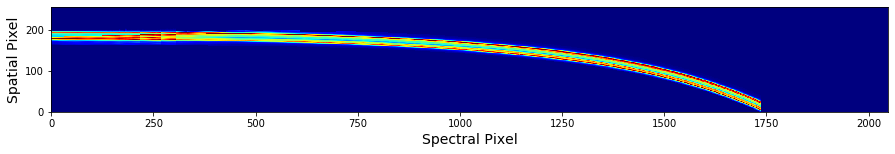

In [20]:
# Subtract the reconsctructed detector from the science frame, and isolate the second order.
scidata[np.isnan(scidata)] = 0.
rebuilt[np.isnan(rebuilt)] = 0.

O2frame = tm.mask_order(scidata-rebuilt, xM2, yM2)
O2frame[O2frame < 0] = 0
O2frame[np.isnan(O2frame)] = 0

plt.figure(figsize=(15,3))
plt.imshow(O2frame, origin='lower', cmap='jet')
plt.xlabel('Spectral Pixel', fontsize=14)
plt.ylabel('Spatial Pixel', fontsize=14)

Voilà, the first pass solution for the second order trace profile.

## Extract Both Orders

In [22]:
T2 = O2frame.astype(float)

T2 = T2 / T2.sum(axis=0)
T2[np.isnan(T2)] = 0.

In [23]:
extract_b = TrpzOverlap([T1, T2], [wv_1, wv_2], orders=[0, 1], scidata=clear, lam_grid=lam_grid, thresh=1e-9,
                    c_kwargs={'thresh':0.0001})

In [24]:
f_k = extract_b.extract()
rebuilt_b = extract_b.rebuild(f_k)

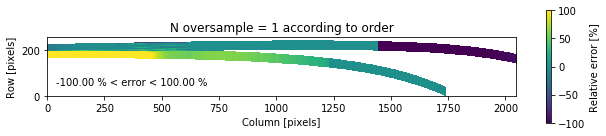

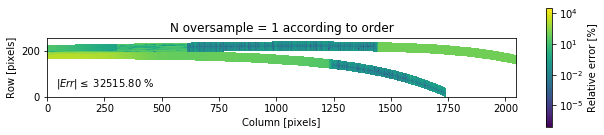

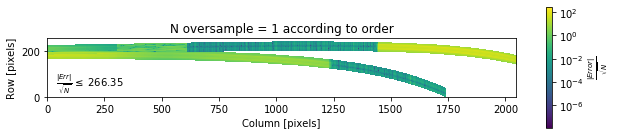

In [25]:
scidata = clear

# Look at errors
n_oversample=1
plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow((rebuilt_b-scidata)/scidata * 100, origin='lower', vmin=-100, vmax=100)
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,46, "{:.2f} % < error < {:.2f} %".format(cmap.vmin, cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow(np.abs(rebuilt_b-scidata)/scidata * 100, norm=LogNorm(), origin='lower')
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,46, r"$| Err | \leq$" + " {:.2f} %".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow(np.abs(rebuilt_b-scidata)/np.sqrt(scidata), norm=LogNorm(), origin='lower')
cmap = plt.colorbar(label=r"$\frac{| Error |}{\sqrt{N}}$")
plt.text(40,46, r"$\frac{|Err|}{\sqrt{N}} \leq$" + " {:.2f}".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()